In [1]:
from pyhive import hive
from pygeocoder import Geocoder

import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Connecting to Hive database
conn = hive.Connection(host = 'hadoop.rcc.uchicago.edu', 
                       port = 10000, 
                       username = 'mtoolsidas', 
                       database = 'dmp_yelp_rs')
cursor = conn.cursor()

In [ ]:
# Getting information from review table and storing in dataframe
query = 'select user_id, business_id, `date`, text, stars from dmp_yelp_rs.review'
cursor.execute(query)
res = cursor.fetchall()
df_review = pd.DataFrame(res, columns = [i[0] for i in cursor.description])

In [4]:
# Getting information from basic data table and storing in dataframe
query = 'select * from business_basicdata'
cursor.execute(query)
res = cursor.fetchall()
df_business = pd.DataFrame(res, columns = [i[0].split('.')[1] for i in cursor.description])

In [10]:
# Joining business and reviews
df_review_slim = df_review[['user_id', 'business_id']]
df_business_slim = df_business[['business_id', 'city', 'state', 'categories', 'simplified_category']]
df_review_business = df_review_slim.join(df_business_slim.set_index('business_id'), on = 'business_id', how = 'inner').dropna()
#pd.concat([df_business_slim, df_review_slim])

## Figuring out where the users are

In [16]:
# Grouping by user and state, getting counts
user_state_df = df_review_business.groupby(['user_id', 'state']).count()

In [17]:
# Give user a home state based on the state they reviewed in. 
user_state_df = user_state_df[['business_id']].sort_values('business_id', ascending=False)
user_state_df['count'] = user_state_df.groupby(['user_id', 'state']).sum() / user_state_df.groupby(['user_id']).sum()

# If a person made half of all reviews in the same state, consider him/her living in the state
Threshold = 0.50001
user_state_df['local'] = user_state_df['count'].apply(lambda x: True if x >= Threshold else False)
user_state_df = user_state_df.reset_index()

In [19]:
# Give each User state labels
user_state_labels = user_state_df[['user_id', 'state']][user_state_df['local'] == True]

In [22]:
# For each review, give user state labels
df_review_ul = df_review.join(user_state_labels.set_index('user_id'), on = 'user_id', how = 'left')
df_review_ul.rename(columns={'state':'user_state'}, inplace=True)
df_review_ul = df_review_ul.dropna()

In [24]:
# For each review, give business state labels
business_state_labels = df_business_slim[['business_id', 'state']]
df_review_labeled = df_review_ul.join(business_state_labels.set_index('business_id'), on = 'business_id', how = 'left')
df_review_labeled.rename(columns={'state':'business_state'}, inplace=True)

In [25]:
df_review_labeled.head()

,user_id,business_id,date,text,stars,user_state,business_state
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,2014-10-11 03:34:02,Apparently Prides Osteria had a rough summer a...,4.0,MA,MA
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,2015-07-03 20:38:25,This store is pretty good. Not as great as Wal...,4.0,MA,MA
3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2010-01-08 02:29:15,I've stayed at many Marriott and Renaissance M...,2.0,FL,FL
4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,The food is always great here. The service fro...,4.0,CO,CO
5,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,2018-01-21 04:41:03,"This place used to be a cool, chill place. Now...",1.0,MA,MA


In [26]:
# See if user was in state or out of state
def check_in_state(row):
    if row['user_state'] == row['business_state']: return 1
    else: return 0
df_review_labeled['in_state'] = df_review_labeled.apply(lambda x: check_in_state(x), axis=1)

In [27]:
df_review_labeled.head()

,user_id,business_id,date,text,stars,user_state,business_state,in_state
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,2014-10-11 03:34:02,Apparently Prides Osteria had a rough summer a...,4.0,MA,MA,1
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,2015-07-03 20:38:25,This store is pretty good. Not as great as Wal...,4.0,MA,MA,1
3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2010-01-08 02:29:15,I've stayed at many Marriott and Renaissance M...,2.0,FL,FL,1
4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,The food is always great here. The service fro...,4.0,CO,CO,1
5,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,2018-01-21 04:41:03,"This place used to be a cool, chill place. Now...",1.0,MA,MA,1


In [29]:
# Crosstab of user state and in state reviews
df_review_labeled_ct = pd.crosstab(df_review_labeled['user_state'], df_review_labeled['in_state'], values = df_review_labeled['stars'], aggfunc = 'mean').fillna(0).drop(['MN', 'ABE', 'DE', 'NH', 'WY', 'VA', 'KY', 'KS'])
df_review_labeled_ct.head(10)

,user_id
user_state,
MA,1894169
TX,1300838
OR,1298709
GA,1024939
FL,989903
BC,572542
OH,395559
CO,115551
WA,87158


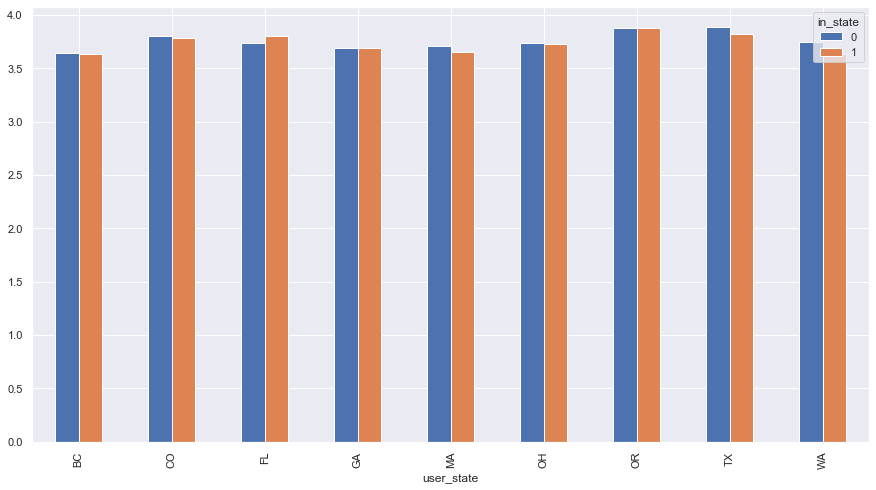

In [47]:
# Plot of average stars in state (1) vs out of state (0) for users 
df_review_labeled_ct.plot.bar()

In [32]:
# Will look into states with more reviews/users
df_review_labeled = df_review_labeled[~df_review_labeled['user_state'].isin(['MN', 'ABE', 'DE', 'NH', 'WY', 'VA', 'KY', 'KS'])]
df_review_labeled = df_review_labeled[~df_review_labeled['business_state'].isin(['MN', 'ABE', 'DE', 'NH', 'WY', 'VA', 'KY', 'KS'])]

In [33]:
# Crosstab of user state and business state for mean stars
df_review_user_business = pd.crosstab(df_review_labeled['user_state'], df_review_labeled['business_state'], values = df_review_labeled['stars'], aggfunc = 'mean').fillna(0)
df_review_user_business = df_review_user_business.drop(' Restaurants', axis = 1)

In [41]:
# Crosstab of user state and business state review counts
df_review_user_business_c = pd.crosstab(df_review_labeled['user_state'], df_review_labeled['business_state']).fillna(0)
df_review_user_business_c = df_review_user_business_c.drop(' Restaurants', axis = 1)
np.fill_diagonal(df_review_user_business_c.values, 0)

In [43]:
sns.set(rc = {'figure.figsize':(15,8)})

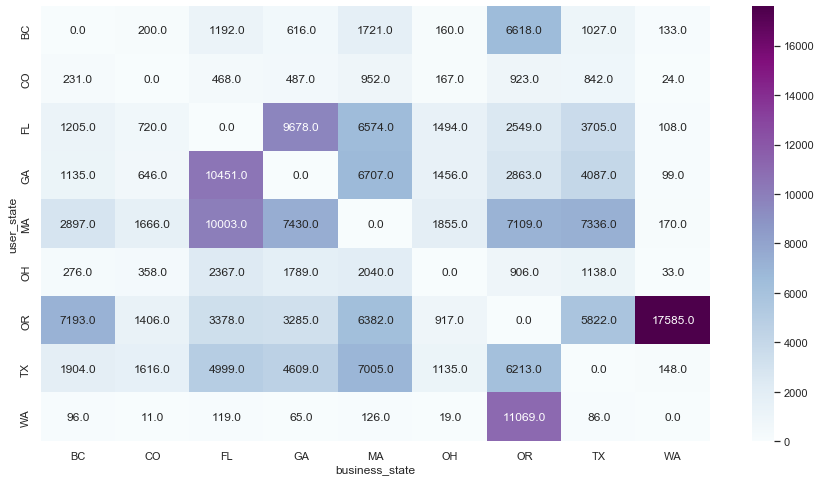

In [44]:
# Out of state review count meatmap -- user state vs. business state
h = sns.heatmap(df_review_user_business_c, annot=True,fmt=".1f", cmap="BuPu")

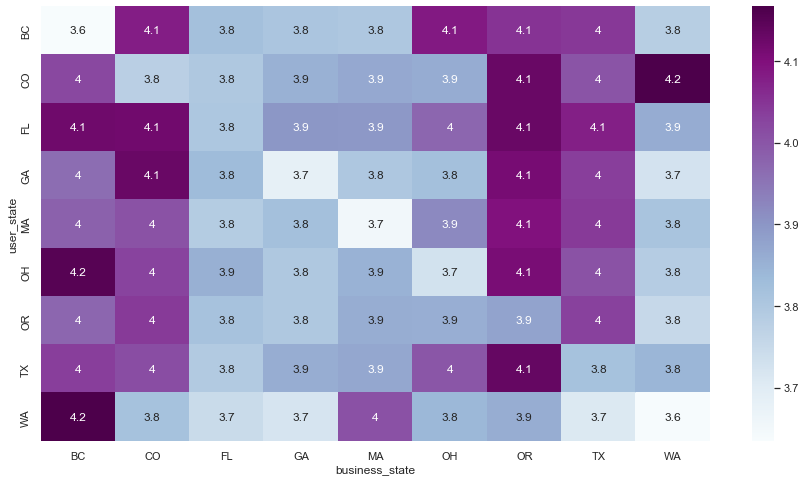

In [45]:
# Out of state review average star meatmap -- user state vs. business state
h = sns.heatmap(df_review_user_business, annot=True, cmap="BuPu")